In [1]:
import numpy as np
from tqdm import tqdm
# what is tqdm?
import cv2
import os 
import shutil
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [2]:
# !where python

In [3]:
img_path = "C:/Users/racco/Documents/python_project/" \
"braintumordetection/archive1/brain_tumor_dataset/"

# Iterate over the "YES" and "NO" folders
# for kelas in os.listdir(img_path):
#     if not kelas.startswith("."):  # Skip hidden files/folders
#         # Count the number of images in the "YES" or "NO" folder
#         img_num = len(os.listdir(img_path + kelas))
#         print(f"Folder: {kelas} - Number of images: {img_num}")
        
#         # Iterate over the files in the folder (either YES or NO)
#         for (n, file_name) in enumerate(os.listdir(img_path + kelas)):
#             img = img_path + kelas + "/" + file_name
            
#             # Copy the first 5 images to the TEST folder
#             if n < 5:
#                 shutil.copy(img, f"TEST/{kelas.upper()}/{file_name}")
#             # Copy 80% of the images to the TRAIN folder
#             elif n < 0.8 * img_num:
#                 shutil.copy(img, f"TRAIN/{kelas.upper()}/{file_name}")
#             # Copy the remaining 15% to the VAL folder
#             else:
#                 shutil.copy(img, f"VAL/{kelas.upper()}/{file_name}")


In [4]:
def load_data(dir_path, img_size=(100,100)):
    # purpose-> Load resized images as np.arrays to workspace
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith("."):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith("."):
                    img = cv2.imread(dir_path + path + "/" + file)
                    # img = cv2.resize(img, img_size)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f"{len(X)} images loaded from {dir_path}")
    return X, y, labels

In [5]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix") #additional line for information
    threshold = cm.max() / 2.0
    cm = np.round(cm, 2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt .text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black")
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

<div style="font-size: 13px;">

## **Background about the Confusion Matrix**
<p> the function, plot_confusion_matrix, is used to plot 
the confusion matrix for a classification model.
It is used to evaluate the performance of a classification model by
showing the true positives, false positives, true negatics and false negatives for each class.
</p>

### 1. **Function Definition**
```python
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
```
- **`cm`**: The confusion matrix itself, a 2D NumPy array that shows the number of correct and incorrect predictions for each class.
- **`classes`**: A list of class names (e.g., `['Cat', 'Dog']`) used to label the axes of the matrix.
- **`normalize`**: A boolean (`True` or `False`) that, when enabled, scales the matrix values into percentages rather than raw counts.
- **`title`**: A string title for the plot.
- **`cmap`**: A matplotlib color map (default is `plt.cm.Blues`) used to visually scale matrix values with color.

---

### 2. **Plotting the Base Confusion Matrix**
```python
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
```
- **`plt.figure(figsize=(6, 6))`**: Creates a figure with a 6x6 inch size.
- **`plt.imshow(cm, interpolation='nearest', cmap=cmap)`**: Displays the confusion matrix as a heatmap. `interpolation='nearest'` keeps cell colors sharp and distinct.
- **`plt.title(title)`**: Sets the title of the plot.
- **`plt.colorbar()`**: Adds a color scale legend to indicate the intensity values.

---

### 3. **Setting Axis Labels and Ticks**
```python
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)
```
- **`tick_marks = np.arange(len(classes))`**: Generates tick positions for each class.
- **`plt.xticks(..., rotation=90)`**: Sets the class names on the x-axis and rotates them vertically for space.
- **`plt.yticks(...)`**: Sets the class names on the y-axis.

---

### 4. **Normalizing the Matrix (Optional)**
```python
if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
```
- **`if normalize:`**: Checks whether normalization is requested.
- **`cm.astype('float')`**: Ensures floating-point division (not integer division).
- **`cm.sum(axis=1)[:, np.newaxis]`**: Computes row-wise sums and reshapes to column vector for broadcasting.
- **`cm = ...`**: Each row of the confusion matrix is converted to proportions (summing to 1.0).

---

### 5. **Thresholding and Rounding Values**
```python
thresh = cm.max() / 2.
cm = np.round(cm, 2)
```
- **`thresh = cm.max() / 2.`**: Defines a midpoint value for deciding text color contrast (white or black).
- **`cm = np.round(cm, 2)`**: Rounds all matrix values to 2 decimal places for display.

---

### 6. **Adding Text Labels Inside Each Cell**
```python
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
```
- **`itertools.product(...)`**: Loops over all combinations of row and column indices.
- **`plt.text(...)`**: Writes each cell's value as text, centered inside its block.
- **`color="white" if ...`**: Uses white text on darker backgrounds and black text on lighter backgrounds for readability.

---

### 7. **Final Layout and Display**
```python
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
```
- **`plt.tight_layout()`**: Adjusts layout to avoid overlap between elements.
- **`plt.ylabel(...)`**: Labels the y-axis as "True label".
- **`plt.xlabel(...)`**: Labels the x-axis as "Predicted label".
- **`plt.show()`**: Renders and displays the plot.
</div>




In [14]:
train_dir = "C:/Users/racco/Documents/python_project/braintumordetection/TRAIN/"
test_dir = "C:/Users/racco/Documents/python_project/braintumordetection/TEST/"
val_dir = "C:/Users/racco/Documents/python_project/braintumordetection/VAL/"
img_size = (224, 224)

# use predefined function to load the image data into workspace
X_train, y_train, labels_train = load_data(train_dir, img_size)
X_test, y_test, _ = load_data(test_dir, img_size)
X_val, y_val, _ = load_data(val_dir, img_size)

# what is the purpose of "load_data" function?

100%|██████████| 2/2 [00:00<00:00, 11.09it/s]


193 images loaded from C:/Users/racco/Documents/python_project/braintumordetection/TRAIN/


100%|██████████| 2/2 [00:00<00:00, 266.54it/s]


10 images loaded from C:/Users/racco/Documents/python_project/braintumordetection/TEST/


100%|██████████| 2/2 [00:00<00:00, 34.63it/s]

50 images loaded from C:/Users/racco/Documents/python_project/braintumordetection/VAL/


In [15]:
import plotly.graph_objs as go

y = dict()
y[0] = [] # no tumor in train, # no tumor in test, # no tumor in val
y[1] = [] # tumor in train, # tumor in test, # tumor in val

print (y[0], y[1])
print(y)
for set_name in (y_train, y_test, y_val):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

print (y[0], y[1])

# what is the purpose of "y" variable?
    # y[0] will store counts of class 0 (e.g., "no tumor"),
    # and y[1] will store counts of class 1 (e.g., "tumor").

    # The for loop iterates over the three sets of labels 
    # (y_train, y_test, y_val) and counts the occurrences of each class in each set.
    
    # The results are stored in the y dictionary, where y[0] contains counts for class 0 
    # and y[1] contains counts for class 1.
# what is the purpose of the for loop?

trace0 = go.Bar(
    x = ["Train", "Test", "Validation"],
    y = y[0],
    name = "No Tumor",
    marker = dict(color = 'rgb(55, 83, 109)')
)

trace1 = go.Bar(
    x = ["Train", "Test", "Validation"],
    y = y[1],
    name = "Tumor",
    marker = dict(color = 'rgb(26, 118, 255)')
)

data = [trace0,  trace1]
layout = go.Layout(
    title = "Distribution of Classes in Train, Test and Validation Sets",
    barmode = "group",
    xaxis = dict(title = "Sets"),
    yaxis = dict(title = "Number of Images")
)

fig = go.Figure(data = data, layout = layout)
# iplot(fig)
fig.show()

[] []
{0: [], 1: []}
[74, 5, 19] [119, 5, 31]


In [16]:
# Code to plot image samples
def plot_samples(X, y, labels, n=50):
    # creates a gridplot for desired number of images (n) from the dataset
    for index in range(len(labels)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        # what is the role of "j" and "i" variables?
        # j is the number of columns, and i is the number of rows.

        plt.figure(figsize=(15, 6))
        c = 1 
        for img in imgs:
            plt.subplot(i, j, c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1

        plt.suptitle("Tumor:{}".format(labels[index]), fontsize=20)
        plt.show()

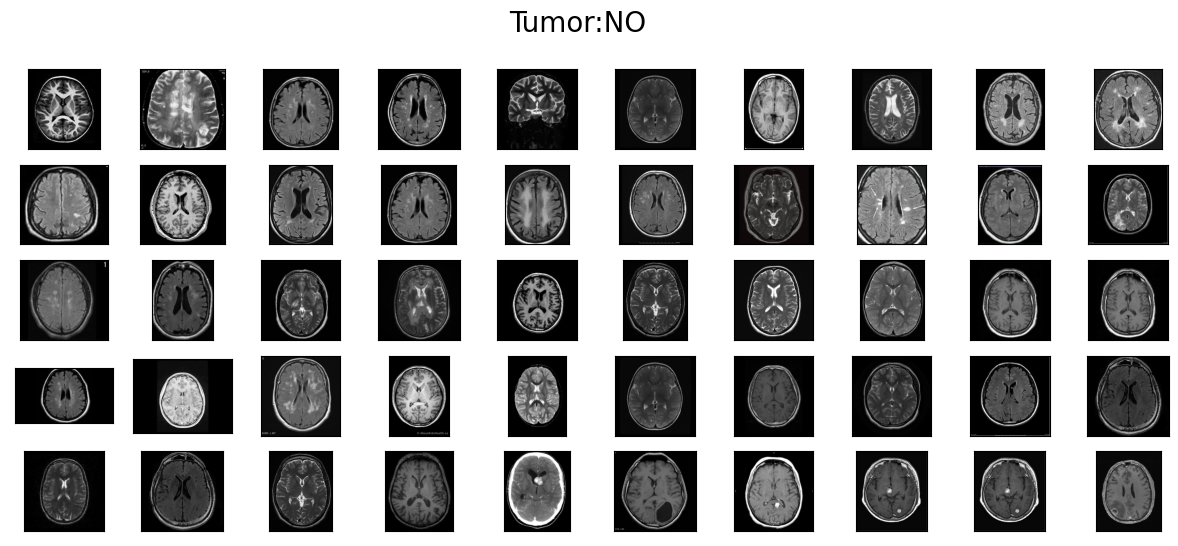

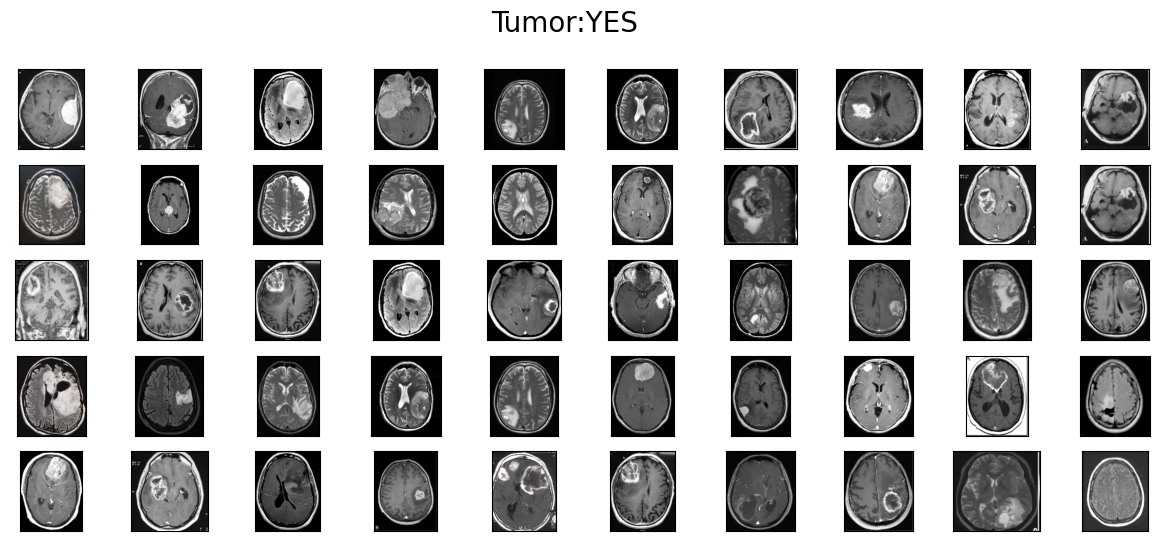

In [17]:
plot_samples(X_train, y_train, labels_train, n=50)
# the purpose of "plot_samples" function
    # The function takes a dataset of images (X), their corresponding labels (y), 
    # and a dictionary of labels (labels) as input. It creates a grid plot of n images 
    # for each class in the dataset, allowing for visual inspection of the samples.

<div style="font-size: 13px;">

As you can see, images have different width and height and diffent size of "black corners". Since the image size for VGG-16 imput layer is (224,224) some wide images may look weird after resizing. Histogram of ratio distributions (ratio = width/height):

</div>

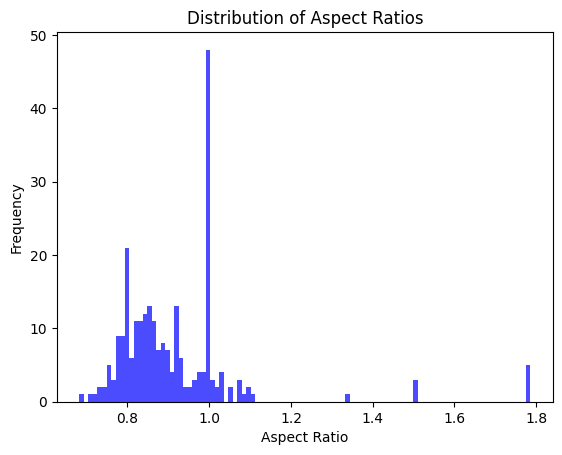

In [18]:
ratio_list = []
for set in (X_train, X_test, X_val):
    for img in set:
        ratio = img.shape[1] / img.shape[0]
        ratio_list.append(ratio)

plt.hist(ratio_list, bins=100, color='blue', alpha=0.7)
# plt.hist(ratio_list)

plt.title("Distribution of Aspect Ratios")
plt.xlabel("Aspect Ratio") 
plt.ylabel("Frequency")
plt.show()

In [19]:
def crop_imgs(set_name, add_pixels_value=0):
    # purpose-> to find the extreme points on an image (using cv2)
    # and crop the image to a square shape
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Convert to grayscale
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        # Apply Gaussian blur to smooth the image

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thersh = cv2.erode(thresh, None, iterations=2)
        # Erode the image to remove noise
        thersh = cv2.dilate(thersh, None, iterations=2)
        # Dilate the image to restore the shape

        # find the contours in the thresholded image, then grab the
        # largest one (assuming this is the main object in the image)
        cnts = cv2.findContours(thersh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)
        # Find the largest contour in the image

        # find the exterme points for the contour
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1] - ADD_PIXELS:extBot[1] + ADD_PIXELS,
                        extLeft[0] - ADD_PIXELS:extRight[0] + ADD_PIXELS].copy()
        # Crop the image using the extreme points

        set_new.append(new_img)

    return np.array(set_new)
# what is the purpose of "crop_imgs" function?

<div style="font-size: 13px;">

### **What "crop_imgs" function do**
the following is a set of visualization of:
- Original image
- Biggest contour on a target image
- Extreme points on a target image (detected and calculated using cv2)
- Resulting image crop

</div>

In [20]:
# def save_new_images(x_set, y_set, folder_name):
#     i = 0
#     for (img, imclass) in zip(x_set, y_set):
#         if imclass == 0:
#             cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
#         else:
#             cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
#         i += 1

In [21]:
# !mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

# save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
# save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
# save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')